# **PREPROCESING AND CLUSTERING**
- Gonzalo Rivera del Pino
- Cristina Sandoval Nuño


# Libraries

In [1]:
# numpy
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatch
import matplotlib.cm as cm
from matplotlib import style
from matplotlib.axes import Axes
style.use("ggplot") or plt.style.use("ggplot")

# scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

# sklearn
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.metrics import silhouette_score
from scipy.spatial import distance_matrix

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [ ]:
df = pd.read_csv("grades.csv")

### Estudio de los datos antes del pre proc

In [ ]:
df.head()

,Unnamed: 0,ML,LA,OR,BD,ST,PR
0,1,0.77,82.0,6.0,6.7,81.0,A
1,2,0.63,78.0,NaN,7.0,81.0,A
2,3,0.75,73.0,7.0,6.6,81.0,A
3,4,0.55,72.0,6.0,7.0,68.0,B
4,5,0.63,63.0,6.0,7.0,63.0,B


La primera columna una vez tenemos el df es innecesaria, ya que indica el número de la fila a la que pertenece, que ya aparece al ser un df, por lo tanto la eliminamos


In [ ]:
if 'Unnamed: 0' in df.columns: del df['Unnamed: 0'] 
df.head() # Comprobamos que se haya eliminado bien

,ML,LA,OR,BD,ST,PR
0,0.77,82.0,6.0,6.7,81.0,A
1,0.63,78.0,NaN,7.0,81.0,A
2,0.75,73.0,7.0,6.6,81.0,A
3,0.55,72.0,6.0,7.0,68.0,B
4,0.63,63.0,6.0,7.0,63.0,B


Podemos ver que:
- Las notas de ML pertenecen al intervalo [0,1] -> var. contínua
- Las notas de LA pertenecen al intervalo [0,100] -> var. discreta
- Las notas de OR pertenecen al intervalo [0,10] -> var. discreta
- Las notas de BD pertenecen al intervalo [0,10] -> var. contínua
- Las notas de ST pertenecen al intervalo [0,100]-> var
- Las notas de PR pertenecen a la escala [A,B,C,D,E] -> variable cualitativa ordinal

In [ ]:
subjects = list(df.columns)

In [ ]:
print(f'Número de alumnos: {df.shape[0]}, Número de asignaturas: {df.shape[1]}')

Número de alumnos: 86, Número de asignaturas: 6


--------------
Tenemos las notas de 86 alumnos, ¿Algún alumno repetido?

In [ ]:
print(f'¿Hay columnas repetidas (o dos alumnos con exactamente las mismas notas)? --> {not (df[df.duplicated()==True]).empty}')

¿Hay columnas repetidas (o dos alumnos con exactamente las mismas notas)? --> False


In [ ]:
df.describe()

,ML,LA,OR,BD,ST
count,74.000000,73.000000,77.000000,81.000000,75.00000
mean,0.394054,48.972603,4.636364,4.598765,44.08000
std,0.214194,16.369834,1.087115,1.504285,21.19138
min,-0.120000,-3.000000,1.000000,0.900000,14.00000
25%,0.300000,40.000000,4.000000,3.500000,31.50000
50%,0.420000,51.000000,5.000000,4.900000,40.00000
75%,0.527500,60.000000,5.000000,5.700000,53.00000
max,1.200000,82.000000,7.000000,7.000000,152.00000


### Graphics (non processed data)

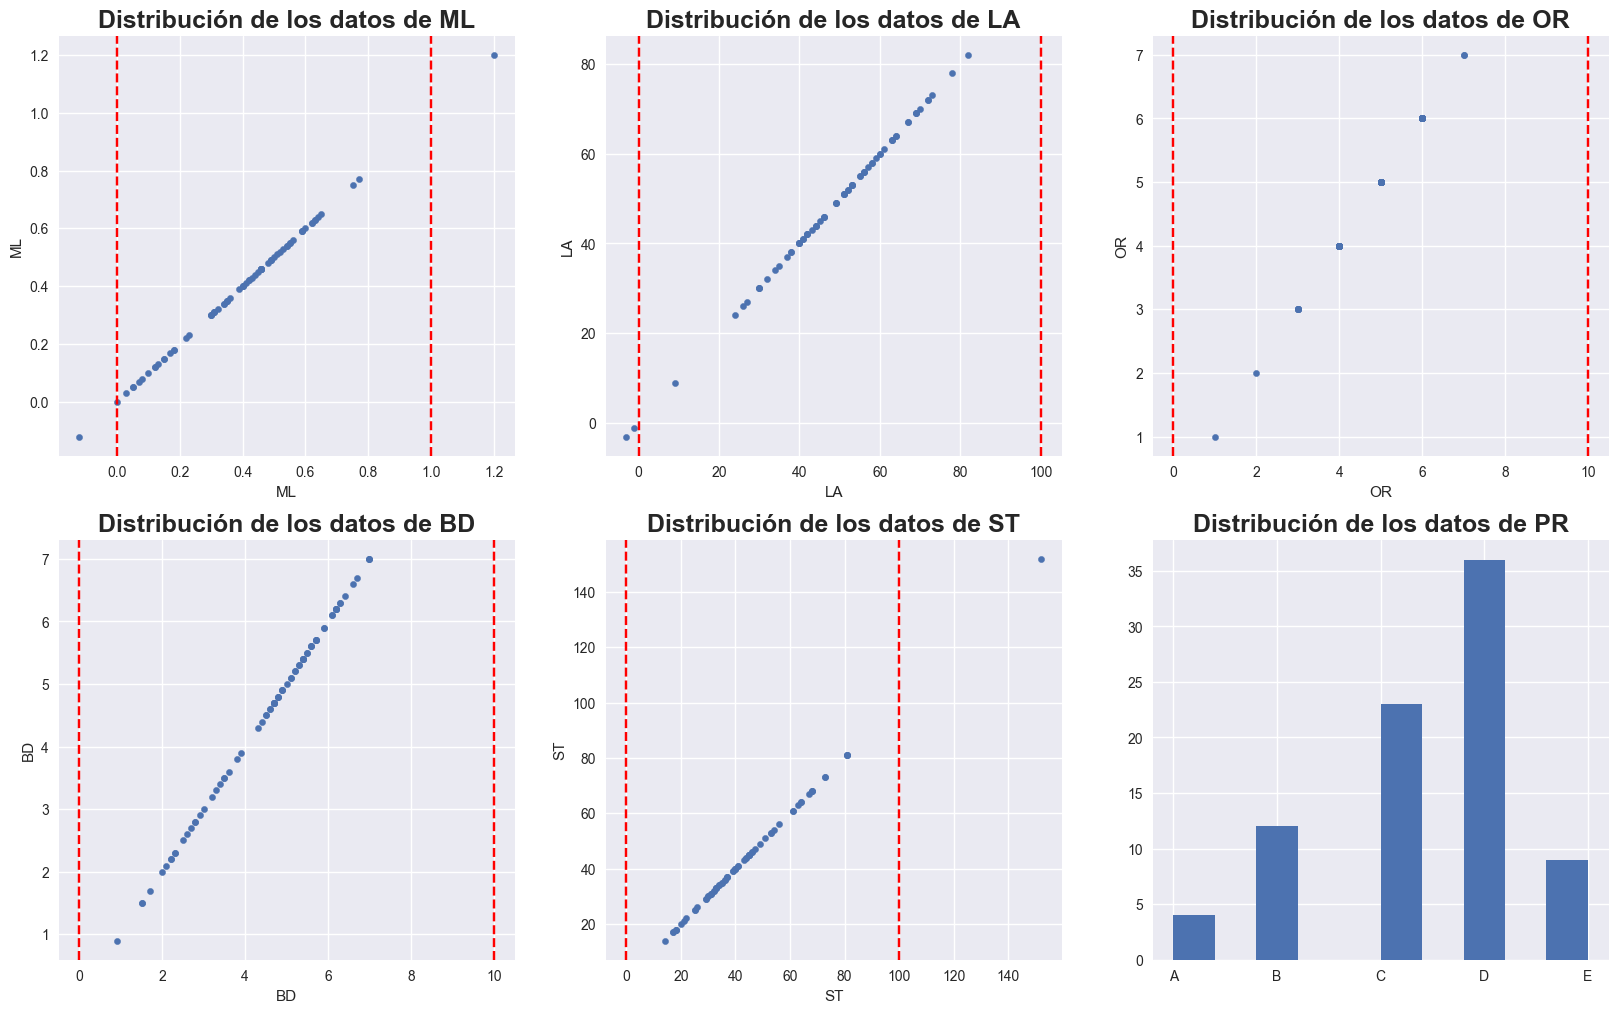

In [ ]:
plt.style.use('seaborn') # plot style

vert_lines = [(0, 1), (0, 100), (0, 10), (0, 10), (0, 100)]

j = 1 # index for subplots 
plt.figure(figsize=(20,12))

for subject in subjects:
    plt.subplot(2,3,j)
    current_ax = plt.gca()
        
    if subject != 'PR':
        df.plot.scatter(subject, subject, ax=current_ax)
        plt.axvline(x=vert_lines[j-1][0], color='r', linestyle='dashed')
        plt.axvline(x=vert_lines[j-1][1], color='r', linestyle='dashed')

    else:
        df[subject].hist()
        
    plt.title(f'Distribución de los datos de {subject}', fontdict={'weight': 'bold', 'size': 18})

    j += 1

plt.show()

-----------------
Realizamos unos boxplots donde ver de forma gráfica los estadísticos más importantes

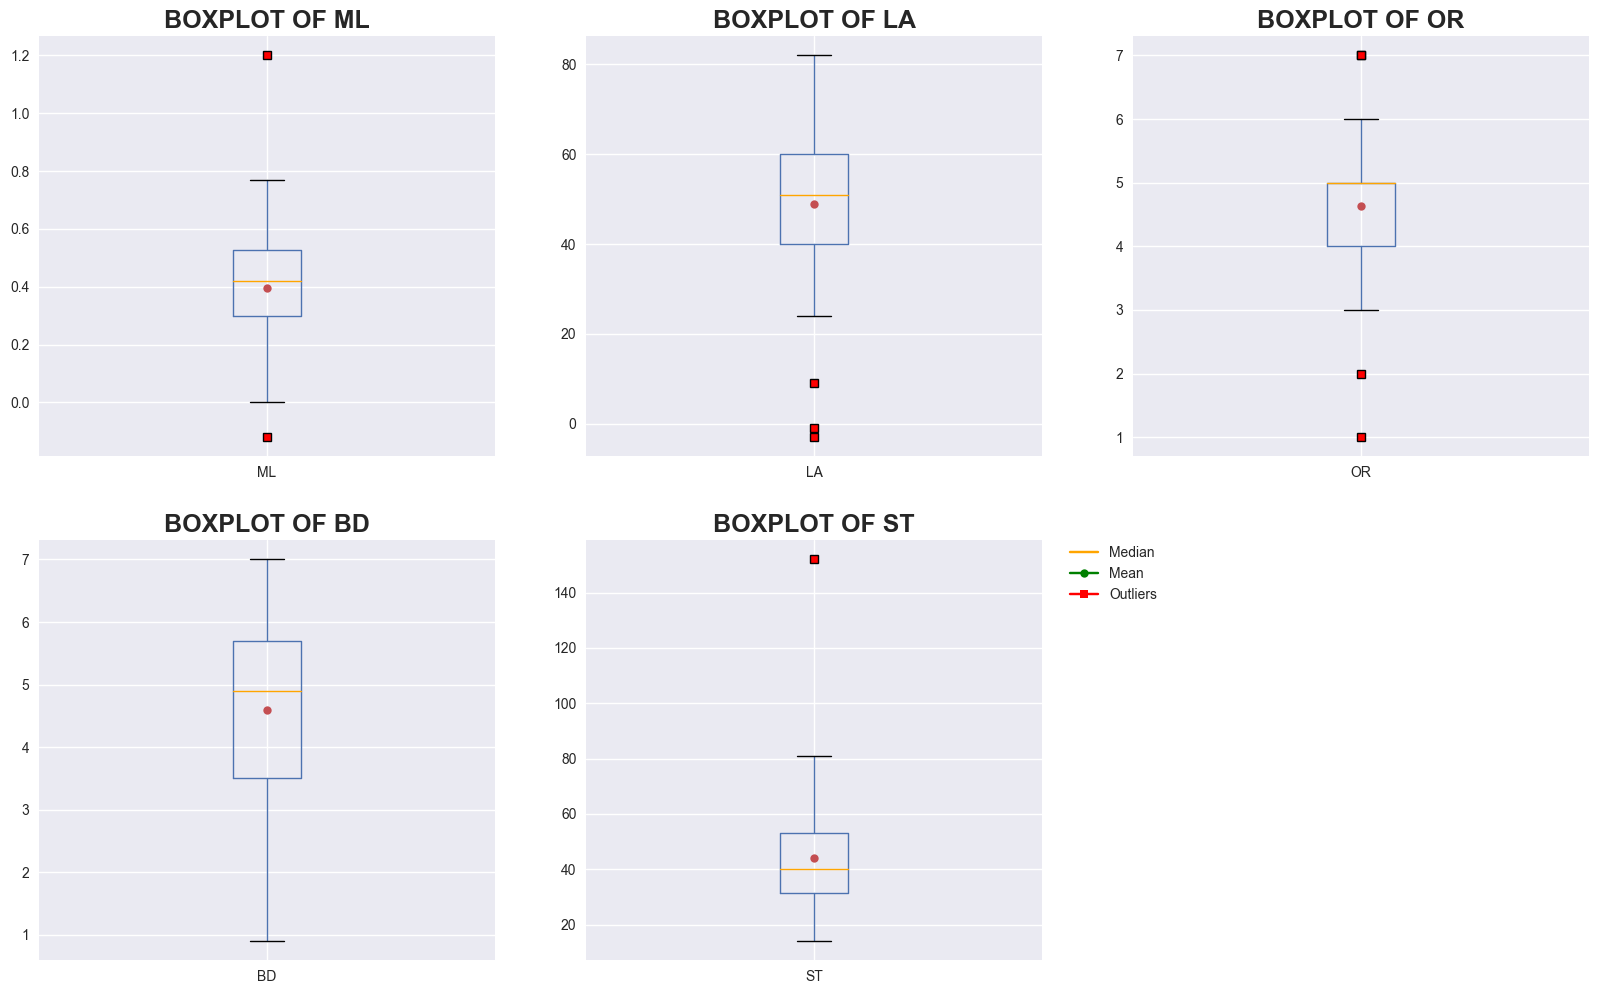

In [ ]:
# handles of the legend
green_circle = mlines.Line2D([], [], color='green', markersize=6, marker='o', label='Mean')
orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Median')
red_square_2 = mlines.Line2D([], [], color='red', markersize=6, marker='s',
                             label='Outliers', markeredgecolor="black")

red_square = dict(markerfacecolor='r', marker='s') # for outliers

j = 1
plt.figure(figsize=(20,12))

# Creation of boxplots
for subject in subjects[0:5]:
    plt.subplot(2,3,j)
    current_ax = plt.gca()

    # NOTA IMPORTANTE Para los boxplots no se han tenido en cuenta los nan values
    df.boxplot(subject, flierprops=red_square, showmeans=True, medianprops={"color": 'orange', "linewidth": 1}, meanprops={'marker':'o'}, ax=current_ax)

    plt.title(F'BOXPLOT OF {subject.upper()}', fontdict={'weight': 'bold', 'size': 18})

    j += 1

plt.legend(handles=[orange_line, green_circle, red_square_2], loc='upper left', borderaxespad=0., bbox_to_anchor=(1.05, 1))

plt.show()

### Scaling

Al ser todo notas el scaling es fácil (pasaremos todas las notas a 0-10). Será unn poco más complejo para las notas de probabilidad donde las notas son categóricas

In [ ]:
# Estaba en escala (0,1)
df["ML"] *= 10

# Estaban en escala (0,10)
df["LA"] /= 10
df['ST'] /= 10

Para la conversión de las variables de la columna PR hemos usado una relación lineal con la media de las notas del alumno y el rango en el que está su nota de PR, los rangos que hemos considerado son los siguientes:
- A ∈ [8,10]
- B ∈ (8,6]
- C ∈ (6,4]
- D ∈ (4,2]
- E ∈ (2,0]

Si por ejemplo un alumno tiene media 50 y tiene una A en PR entonces su nota será un 90. En cambio si tiene media 0 su nota será un 80


In [ ]:
df["mean"] = df.iloc[:, [0,1,2,3,4]].mean(axis = 1)

for i in range(0, len(df["PR"])):
    if df["PR"][i] == "A":
        df["PR"][i] = round((df["mean"][i] / 5) + 8, 1)
    elif df["PR"][i] == "B":
        df["PR"][i] = round((df["mean"][i] / 5) + 6, 1)
    elif df["PR"][i] == "C":
        df["PR"][i] = round((df["mean"][i] / 5) + 4, 1)
    elif df["PR"][i] == "D":
        df["PR"][i] = round((df["mean"][i] / 5) + 2, 1)
    elif df["PR"][i] == "E":
        df["PR"][i] = round((df["mean"][i] / 5), 1)

if 'mean' in df.columns: del df['mean']

### No sense data treatment

Pondremos a NAN aquellos valores sin sentido, es decir aquellas notas menores que 0 o mayores que 10. No eliminamos dichas filas porquer tenemos muy pocas instancias

In [ ]:
for subject in subjects:
    indx = []
    indx = df[df[subject]<0].index.to_list() + df[df[subject]>10].index.to_list()

    for ind in indx:
        df[subject][ind] = np.nan

# Comprobamos que estén ya bien los rangos
df.describe()

,ML,LA,OR,BD,ST
count,72.000000,71.000000,77.000000,81.000000,74.000000
mean,3.900000,5.040845,4.636364,4.598765,4.262162
std,1.851608,1.411643,1.087115,1.504285,1.713260
min,0.000000,0.900000,1.000000,0.900000,1.400000
25%,3.000000,4.100000,4.000000,3.500000,3.125000
50%,4.200000,5.100000,5.000000,4.900000,4.000000
75%,5.225000,6.000000,5.000000,5.700000,5.250000
max,7.700000,8.200000,7.000000,7.000000,8.100000


### Missing data

¿Faltan datos?

In [ ]:
nans = df.isna().sum()
print(nans, '\n')
print(f"Faltan {nans.sum()} datos en la tabla")

ML    14
LA    15
OR     9
BD     5
ST    12
PR     2
dtype: int64 

Faltan 57 datos en la tabla


Con tan pocos datos y tantos nulls sería muy erróneo eliminar aquellas filas que contengan un NA. Hemos decidido imputar los missing values con un KNN con k=2

<a href=https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html> Documentacion del imputer KNN</a>

In [ ]:
imputer = KNNImputer(n_neighbors=2)
df = pd.DataFrame(imputer.fit_transform(df), columns=subjects)

Comprobación de que ya no hay na values

In [ ]:
nans = df.isna().sum()
print(nans)
print(f"faltan {nans.sum()} datos en la tabla")

ML    0
LA    0
OR    0
BD    0
ST    0
PR    0
dtype: int64
faltan 0 datos en la tabla


# Clustering

## Partitional clustering

<a href=https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html>**enlace a doc de k-means**</a>

### Mandatory part

#### Silhoutte score

 Silhouette coefficient is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1, meaning 1 a perfect clustering.

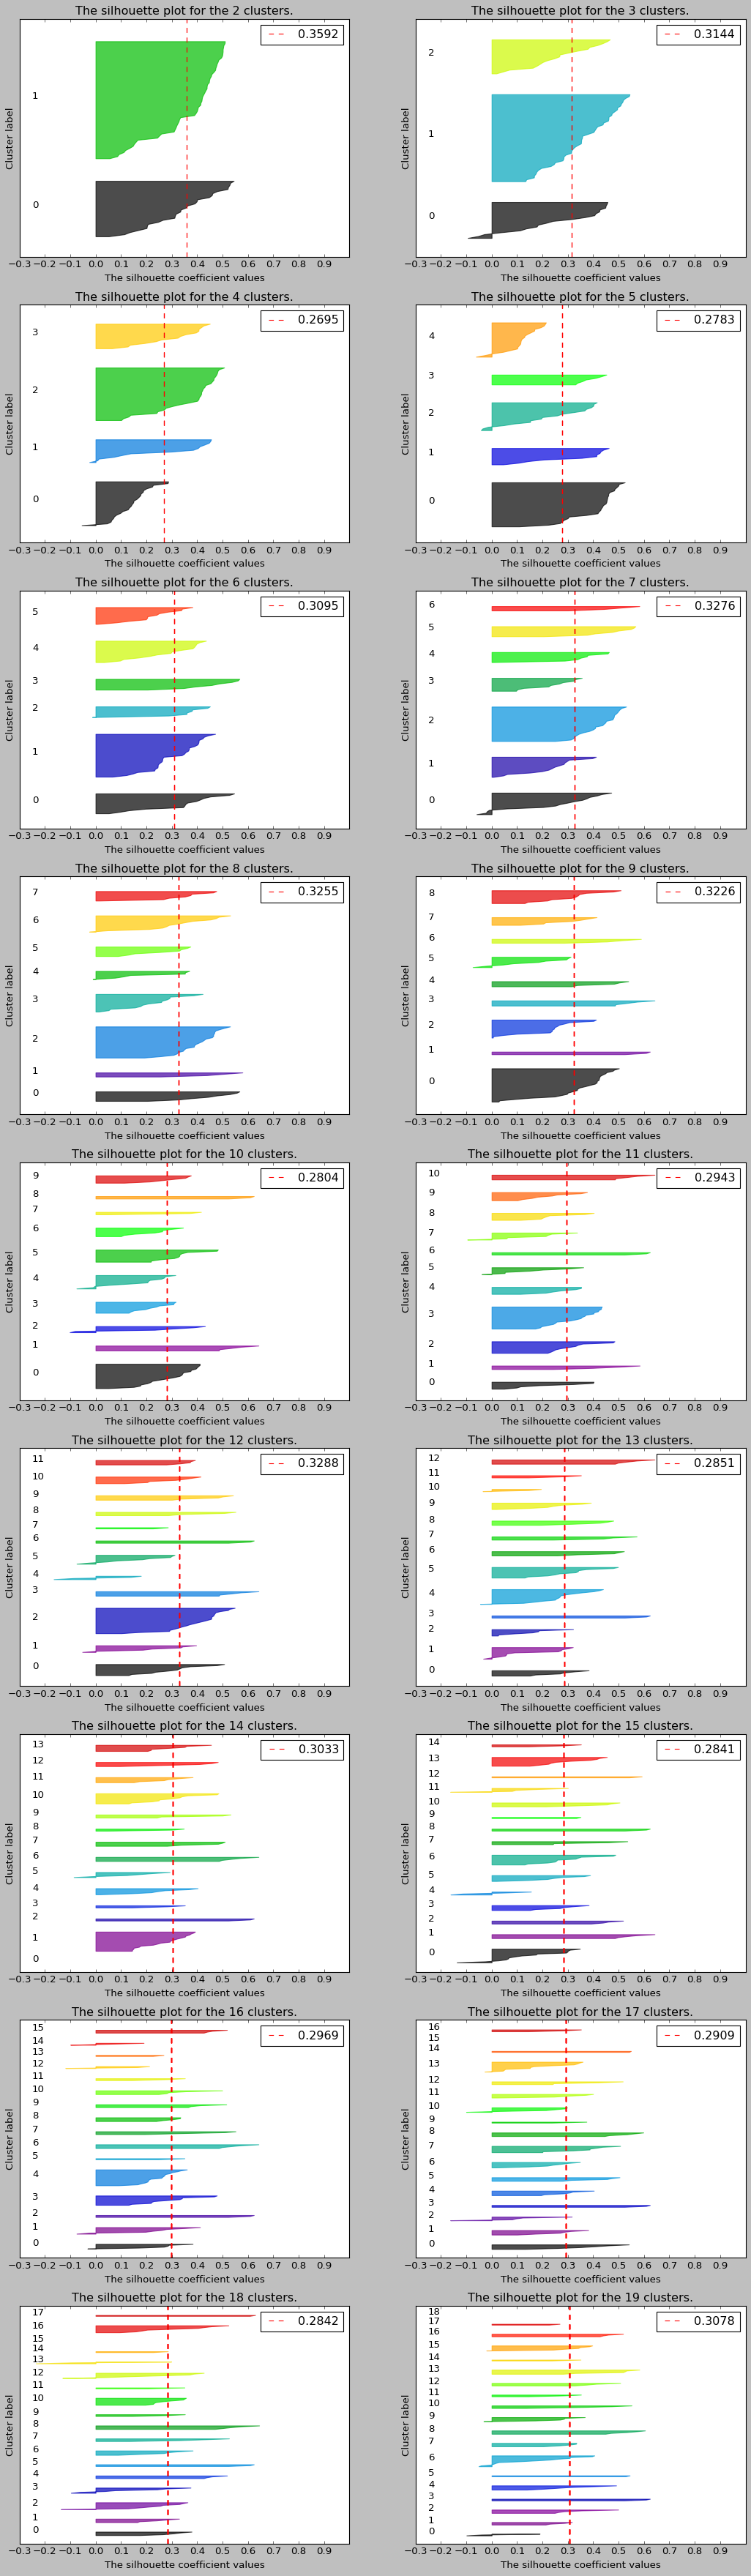

In [ ]:
plt.style.use('classic') # plot style

# Variables intialization
x = [i for i in range(2,20)]
sse_rand = []
sse_plus = []

plt.figure(figsize=(16, 60))

for n_clusters in x:
    
    """
    K-MEANS MODEL APPLICATION AND CALCULATION OF SSE FOR THE ELBOW METHOD
    """
    
    clusterer_rand = KMeans(n_clusters=n_clusters, n_init=20, init='random').fit(df.iloc[:, 0:6]) # Apply the model with init random
    clusterer_plus = KMeans(n_clusters=n_clusters, n_init=20, init='k-means++').fit(df.iloc[:, 0:6]) # Apply the model with init k-means++
    sse_rand += [clusterer_rand.inertia_] # Calculate de sum of squared distance of each dataset point and its centroid
    sse_plus += [clusterer_plus.inertia_] # Calculate de sum of squared distance of each dataset point and its centroid
    
    """
    CREATION OF THE SILHOUETTE PLOTS FOR DE DIFFERENT N_CLUSTERS INITIALIZATION
    """
    # Create a subplot with 1 row and 2 columns
    plt.subplot(10, 2, n_clusters-1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.3, 1]
    plt.xlim([-0.3, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df.iloc[:, 0:6]) + (n_clusters + 1) * 10])

    cluster_labels = clusterer_plus.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(df.iloc[:, 0:6], cluster_labels, metric='euclidean')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(df.iloc[:, 0:6], cluster_labels, metric='euclidean')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.legend([round(silhouette_avg, 4)])
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers
        plt.text(-0.25, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"The silhouette plot for the {n_clusters} clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    
    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(-0.3, 1, 0.1))
    

plt.show()

#### Elbow method

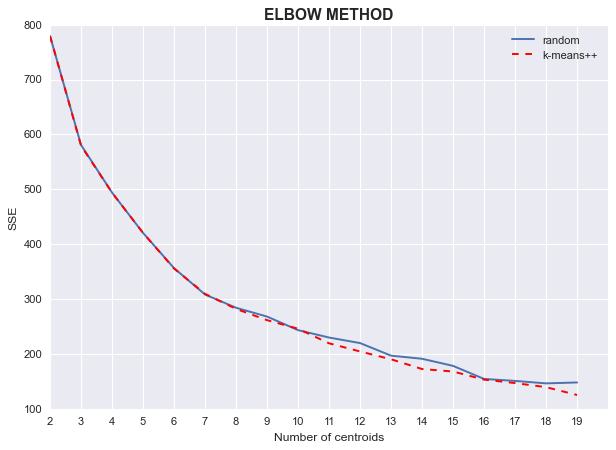

In [ ]:
plt.style.use('seaborn') # plot style
plt.figure(figsize=(9,6))
plt.plot(x, sse_rand)
plt.plot(x, sse_plus, 'r--')
plt.legend(['random', 'k-means++'])
plt.title(f'ELBOW METHOD', fontdict={'weight': 'bold', 'size': 14})
plt.xlabel('Number of centroids')
plt.ylabel('SSE')
plt.xticks(x)
plt.show()

**OBSERVACIONES SOBRE EL ELBOW METHOD**
- Observamos que para un número de clusters entre 2 y 11 el sse (sum square distance) es prácticamente el mismo para las dos formas de init
- Analizando la gráfica vemos que para k=7 la reducción del  ``sse`` empieza a ser poca por lo tanto basandonos solo en el elbow method el k elegido es 7

**OBSERVACIONES SOBRE EL SILHOUETTE COEFFICIENT**
- Observamos que la media más alta de los silhouette coefficients es para k=2 y luego le siguen k=7 y k=8 (puede cambiar si volvemos a ejecutar pero suele ser así)

**CONCLUSIÓN**: Teniendo en cuenta las dos métricas nuestra elección es dividir los datos en 7 clusters

#### Final execution

Ejecutamos el k-means con 7 clusters y las dos formas de inicialización

In [ ]:
init_forms = ['random', 'k-means++']

for init in init_forms:
    kmean = KMeans(n_clusters=7, n_init=20, init=init).fit(df) # Apply the model   
    sse = kmean.inertia_ # Calculate de sum of squared distance of each dataset point and its centroid
    df[f'cluster ({init})'] = kmean.labels_
    
    silhouette_avg = metrics.silhouette_score(df.iloc[:, 0:6], kmean.labels_)
    silhouette_samples = metrics.silhouette_samples(df.iloc[:, 0:6], kmean.labels_)
    df[f'sil ({init})'] = silhouette_samples
    
    print(f'Inertia for init={init} with 7 clusters: ', round(sse, 4), f'   Silhouettte average for init={init} with 7 clusters: ', round(silhouette_avg, 4))

Inertia for init=random with 7 clusters:  307.6916    Silhouettte average for init=random with 7 clusters:  0.3343
Inertia for init=k-means++ with 7 clusters:  308.7929    Silhouettte average for init=k-means++ with 7 clusters:  0.3352


In [ ]:
set(list(zip(df['cluster (random)'], df['cluster (k-means++)']))) # Comprobamos que hay 7 pares significando esto que el clustering es el mismo

{(0, 2), (1, 6), (2, 1), (2, 6), (3, 4), (4, 3), (5, 5), (6, 0)}

Vemos como los clusters que se hacen con init=random e init=k-means++ son iguales (cambia la etiqueta pero es lo mismo) y por tanto nos quedamos con init=k-means++ (es indiferente)

-----
**ESTUDIAMOS LOS DISTINTOS CLUSTERS**

Borramos las columnas innecesarias

In [ ]:
if 'cluster (random)' in df.columns: del df['cluster (random)'] # eliminamos la columna del cluster con init=random
if 'sil (random)' in df.columns: del df['sil (random)']

**Número de instancias por cluster**

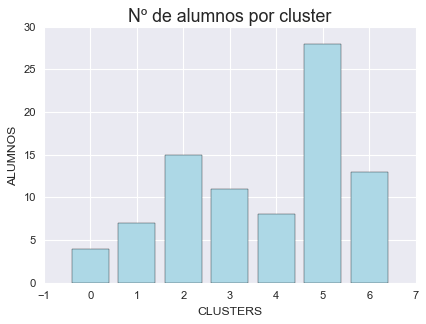

Nº de alumnos por cluster (cluster, nº): 
[(0, 4), (1, 7), (2, 15), (3, 11), (4, 8), (5, 28), (6, 13)]


In [ ]:
cl = sorted(list(df['cluster (k-means++)'].unique()))
num = list(df.groupby('cluster (k-means++)').count().iloc[:, 6])


plt.figure(figsize=(6, 4))
plt.bar(cl, num, color='lightblue')
plt.xlabel('CLUSTERS')
plt.ylabel('ALUMNOS')
plt.title('Nº de alumnos por cluster', fontsize=16)

plt.show()

print('Nº de alumnos por cluster (cluster, nº): ')
print(list(zip(cl, num)))

**Media de las asignaturas por cluster**

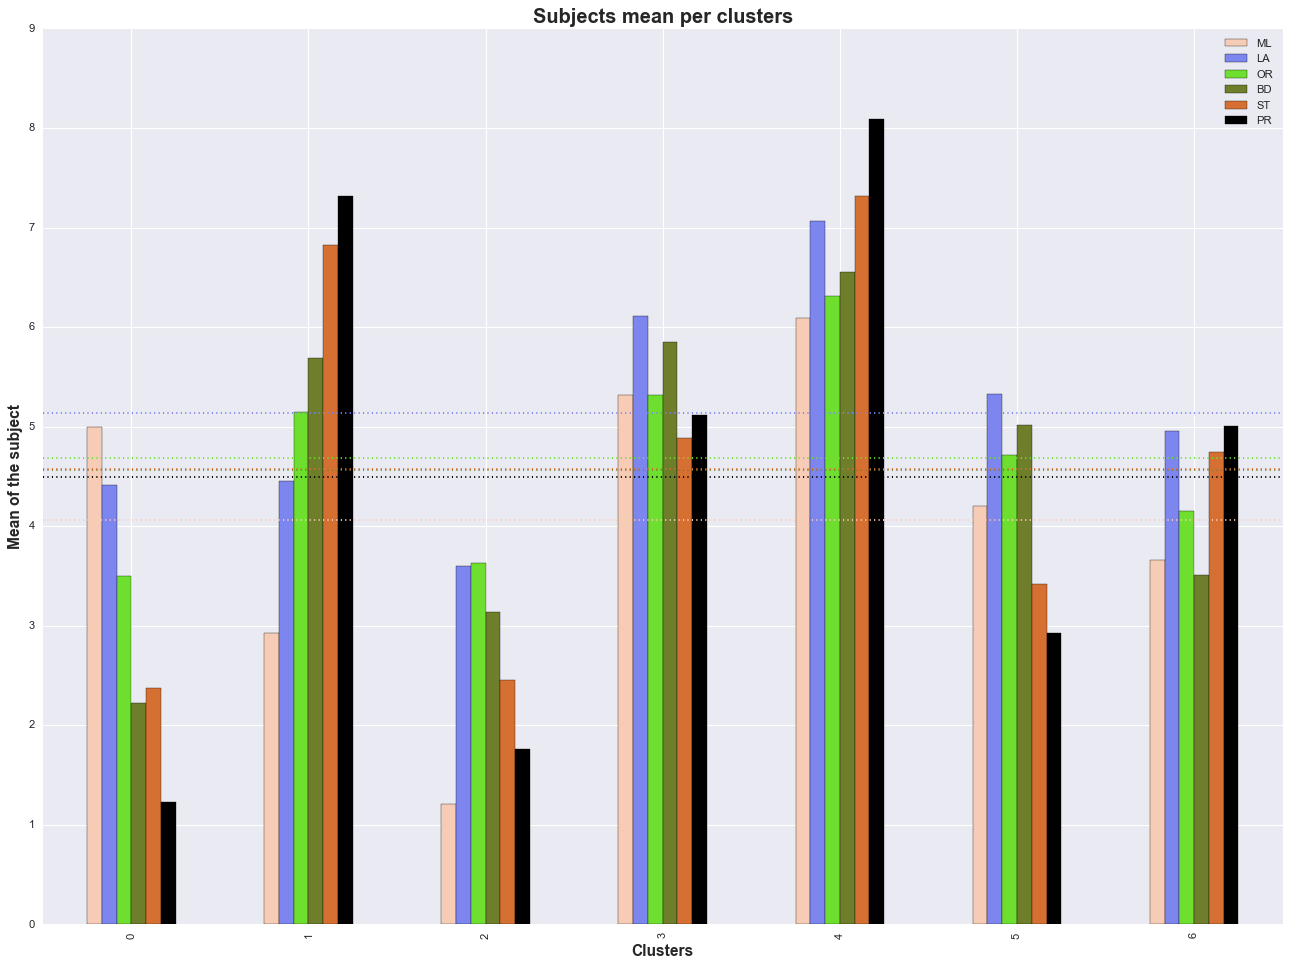

,ML,LA,OR,BD,ST,PR
cluster (k-means++),,,,,,
0,5.000000,4.412500,3.500000,2.225000,2.375000,1.225000
1,2.928571,4.457143,5.142857,5.685714,6.828571,7.314286
2,1.206667,3.600000,3.633333,3.133333,2.460000,1.766667
3,5.322727,6.109091,5.318182,5.854545,4.886364,5.118182
4,6.087500,7.068750,6.312500,6.556250,7.318750,8.087500
5,4.207143,5.326786,4.714286,5.012500,3.417857,2.923214
6,3.665385,4.957692,4.153846,3.511538,4.742308,5.007692


In [ ]:
colors = ['#F7CCB6', '#7D85EF', '#6FDF2F', '#6E7E2B', '#D57032', 'black']

df.groupby('cluster (k-means++)').mean().iloc[:, 0:6].plot.bar(color = colors, figsize=(20, 14))

# DASHED LINES ARE THE TOTAL MEAN OF THE SUBJECTS
means = df.groupby('cluster (k-means++)').mean().iloc[:, 0:6].mean()
for m, c in zip(means, colors):
    plt.axhline(m, linestyle=':', c=c,) 

plt.title('Subjects mean per clusters', fontdict={'weight': 'bold', 'size': 18})
plt.xlabel('Clusters', fontdict={'weight': 'bold', 'size': 14})
plt.ylabel('Mean of the subject', fontdict={'weight': 'bold', 'size': 14})
plt.show()

df.groupby('cluster (k-means++)').mean().iloc[:, 0:6]

**Análisis de los silhouette scores**

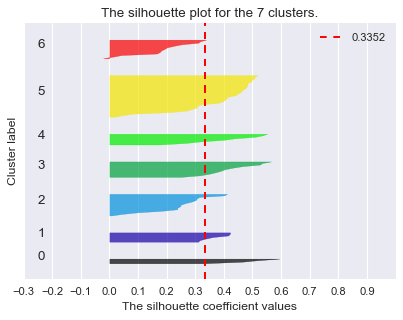

In [ ]:

plt.figure(figsize=(6, 4))

cluster_labels = kmean.labels_

# Silhouette metrics
silhouette_avg = metrics.silhouette_score(df.iloc[:, 0:6], cluster_labels, metric='euclidean')
sample_silhouette_values = metrics.silhouette_samples(df.iloc[:, 0:6], cluster_labels, metric='euclidean')

y_lower = 10
    
for i in range(7):

    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.legend([round(silhouette_avg, 4)])
        
    color = cm.nipy_spectral(float(i) / 7)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    plt.text(-0.25, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

#plt configuration
plt.ylim([0, len(df.iloc[:, 0:6]) + (8) * 10])
plt.xlim([-0.3, 1])
plt.title(f"The silhouette plot for the {7} clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")
    
plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(-0.3, 1, 0.1))

plt.show()

La varianza de los datos de cada cluster y sus silhuette coefficient están inversamente relacionados (no exacto). Los clusters con los silhouettes scores más altos tendrán varianzas más bajas y viceversa

In [ ]:
df_1 = df.groupby('cluster (k-means++)').var().iloc[:, 0:6].mean(axis=1)
df_2 = df.groupby('cluster (k-means++)').mean().iloc[:, 6]

a = pd.concat([df_1, df_2], axis=1)
a.columns=['variances', 'silhouettes']
a

,variances,silhouettes
cluster (k-means++),,
0,0.467187,0.476348
1,0.703194,0.368360
2,1.062028,0.239092
3,0.389273,0.418166
4,0.661376,0.398803
5,0.439425,0.377686
6,0.853024,0.184080


### Partitional clustering with PCA (extra)

In [ ]:
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df.iloc[:, 0:6])

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

pd.DataFrame(data=modelo_pca.components_, columns=subjects, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])


,ML,LA,OR,BD,ST,PR
PC1,0.345396,0.366948,0.428407,0.409444,0.446103,0.442567
PC2,-0.605148,-0.493662,-0.000793,-0.004786,0.444168,0.439072
PC3,0.249948,0.276559,-0.499069,-0.635341,0.301161,0.342950
PC4,0.669819,-0.727801,-0.099939,0.077927,0.059104,0.045763
PC5,-0.057982,0.123212,-0.746304,0.649900,0.026281,0.037769
PC6,0.001915,0.016909,-0.020946,-0.015244,0.713320,-0.700153


Porcentaje de varianza explicada por cada componente

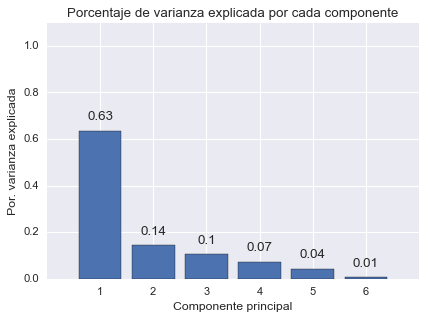

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(subjects)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

Nos quedamos con 2 componentes ya que así podremos representar los clusters en 2D y tienen un porcentaje de varianza explicada de aproximadamente el 80% (lo consideramos suficiente)

------------
Proyección de las observaciones

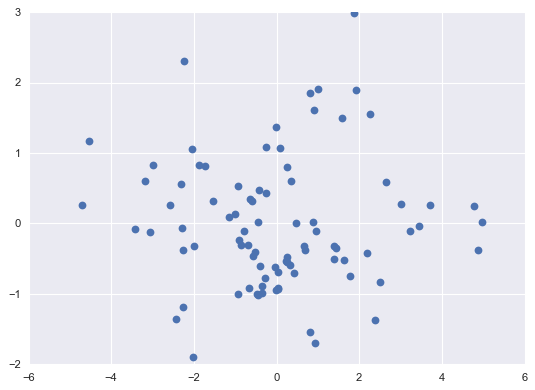

In [ ]:
pca_pipe = make_pipeline(StandardScaler(), PCA(2))
pca_pipe.fit(df.iloc[:, 0:6])

df_PCA = df.iloc[:, 0:6].copy()

proy = pca_pipe.transform(X=df_PCA)
proy = pd.DataFrame(
    proy,
    columns = ['PC1', 'PC2'],
    index   = df_PCA.index
)

df_PCA = pd.concat([df_PCA, proy], axis=1)

plt.plot(df_PCA['PC1'], df_PCA['PC2'], 'o')

Pintamos los datos redimensionados, los clusters y los centroides

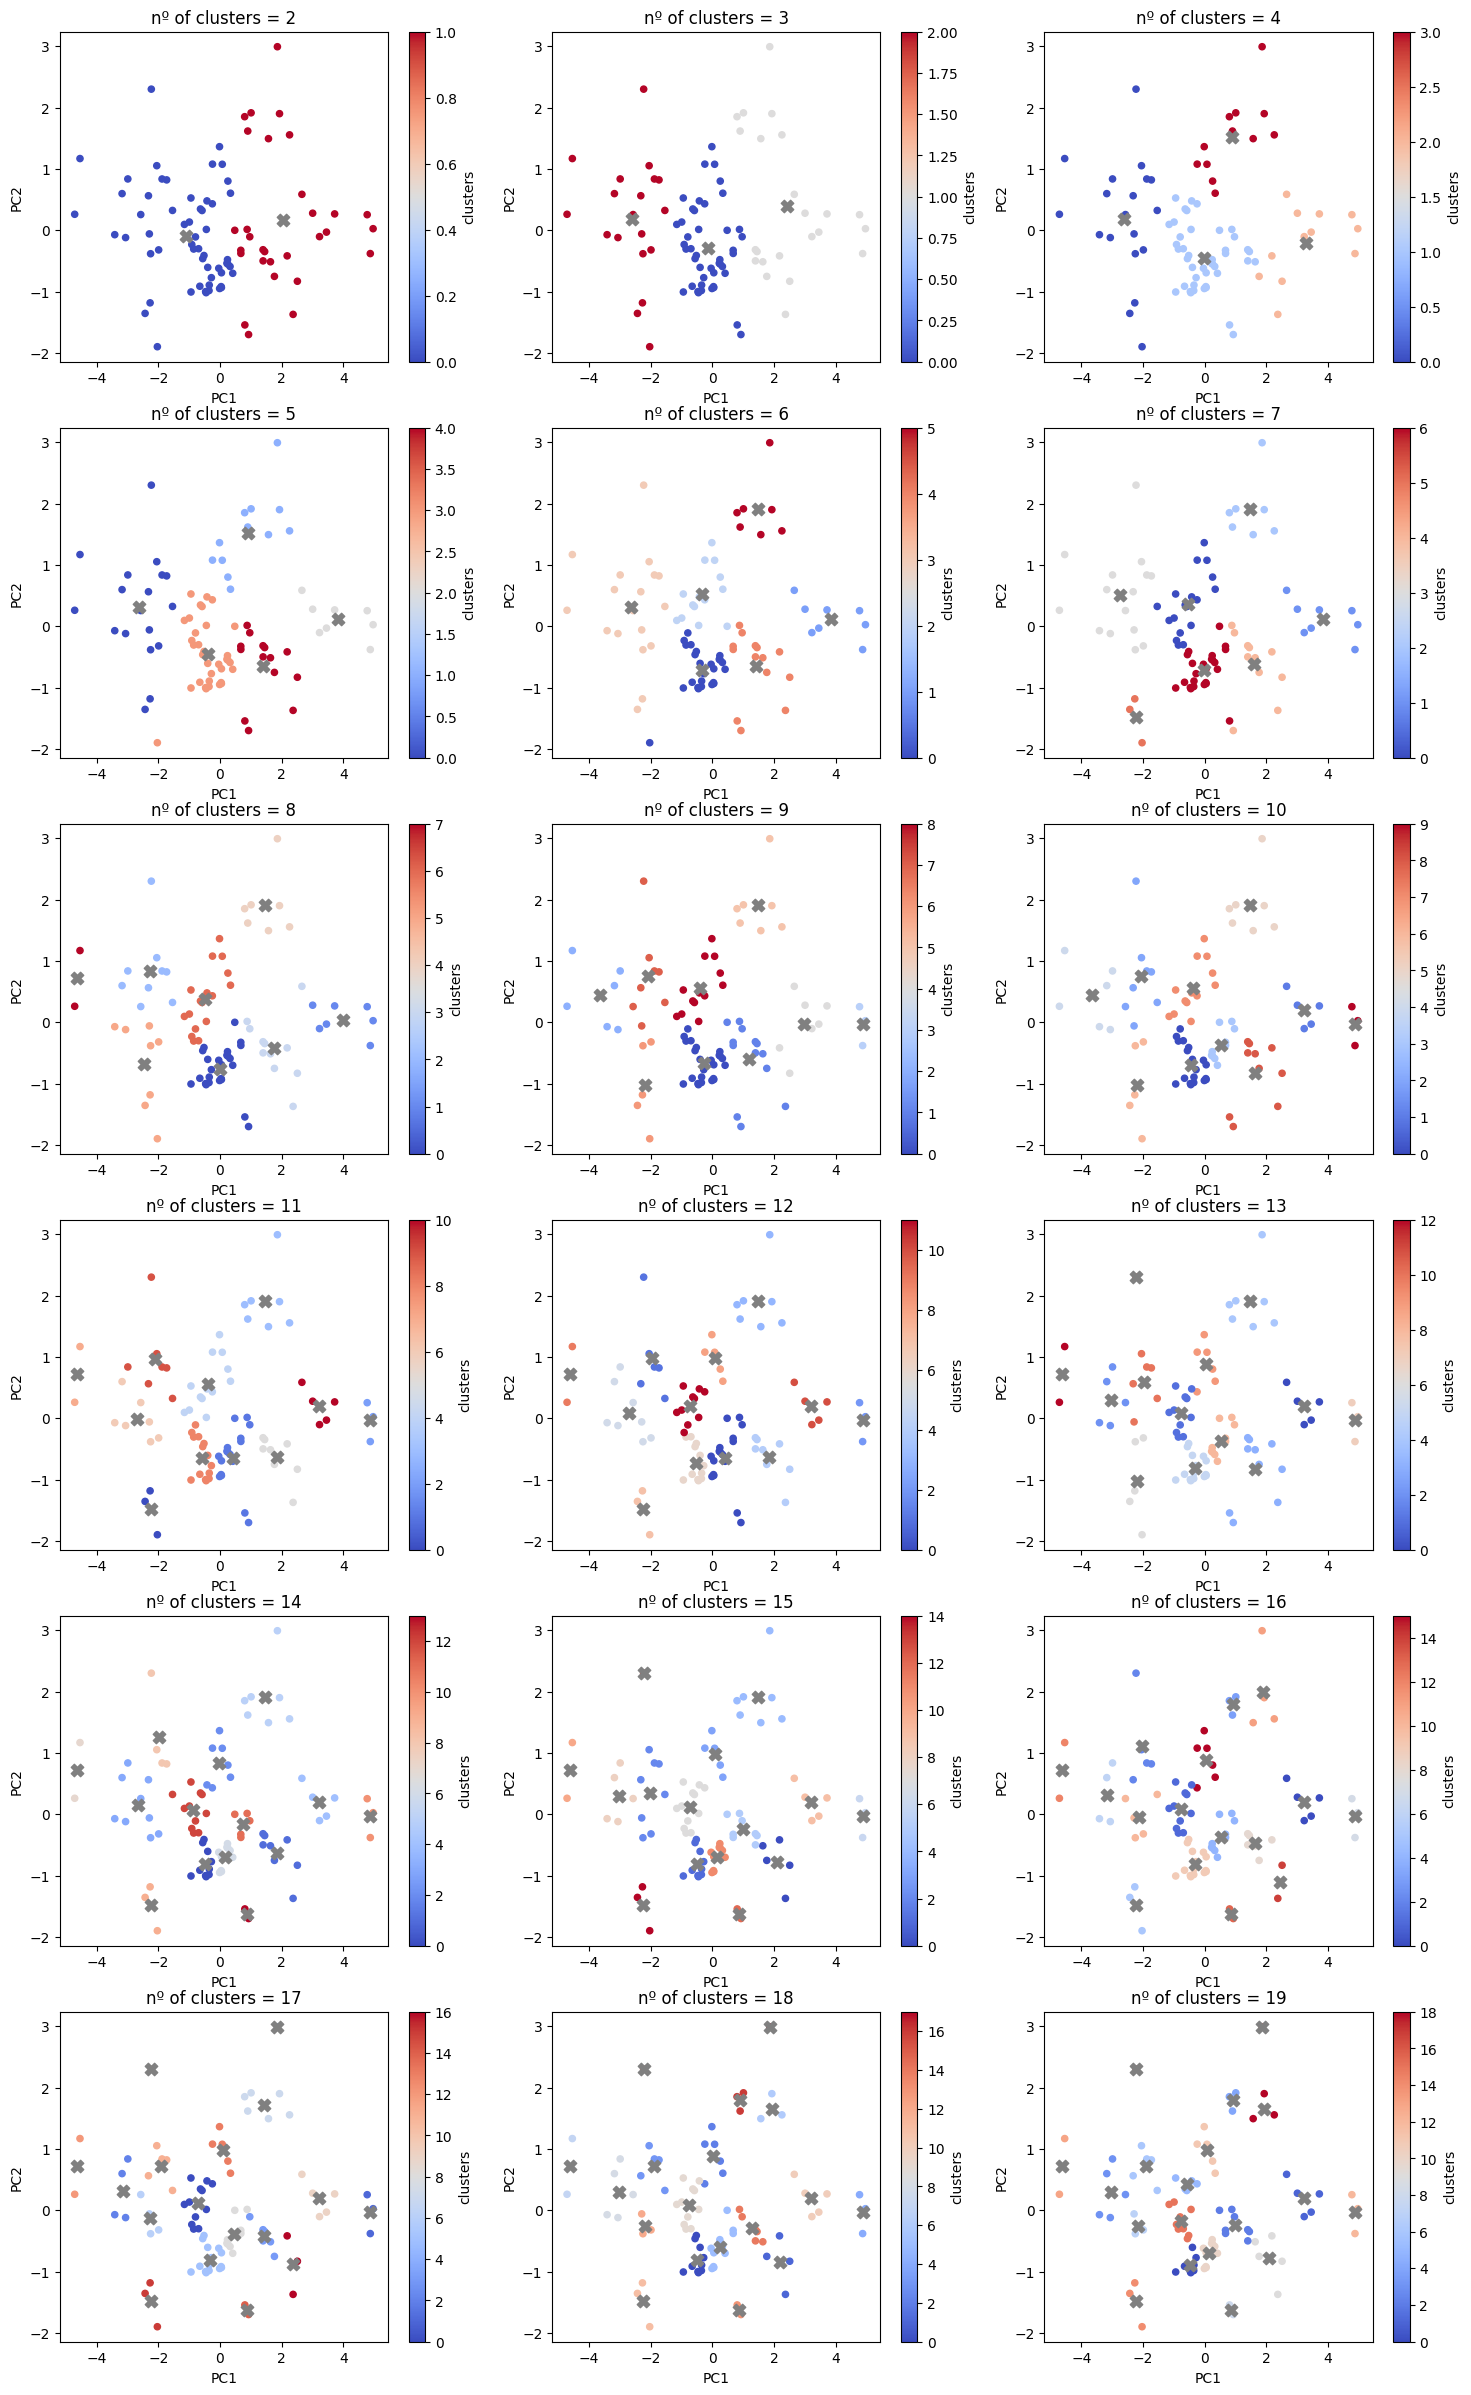

In [ ]:
plt.style.use('default') # plot style
plt.figure(figsize=(18, 30))

x = [i for i in range(2,20)]
sse = []
sil = []

for k in x:
    clusterer = KMeans(n_clusters=k, n_init=20, init='k-means++').fit(df_PCA.loc[:, ['PC1', 'PC2']]) # Apply the model with init random
    
    # Elbow method
    sse += [clusterer.inertia_]


    plt.subplot(6,3,k-1)
    ax = plt.gca()
    
    df_PCA['clusters'] = clusterer.labels_
    df_PCA.plot.scatter(x='PC1', y='PC2', c='clusters', cmap='coolwarm', ax=ax)
    
    centroids = clusterer.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],  marker='X', c='grey', s=80)
    plt.title(f'nº of clusters = {k}')
    
    silhouette_avg = metrics.silhouette_score(df_PCA.loc[:, ['PC1', 'PC2']], clusterer.labels_, metric='euclidean')
    sil += [round(silhouette_avg, 4)]
    
plt.show()

 Silhouette score avg plot

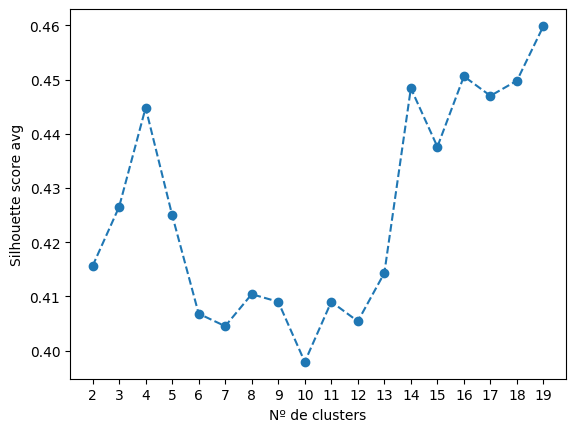

In [ ]:
plt.plot([i for i in range(2,20)], sil, marker='o', linestyle='--')
plt.xlabel('Nº de clusters')
plt.ylabel('Silhouette score avg')
plt.xticks([i for i in range(2,20)])
plt.show()

Plot of elbow method

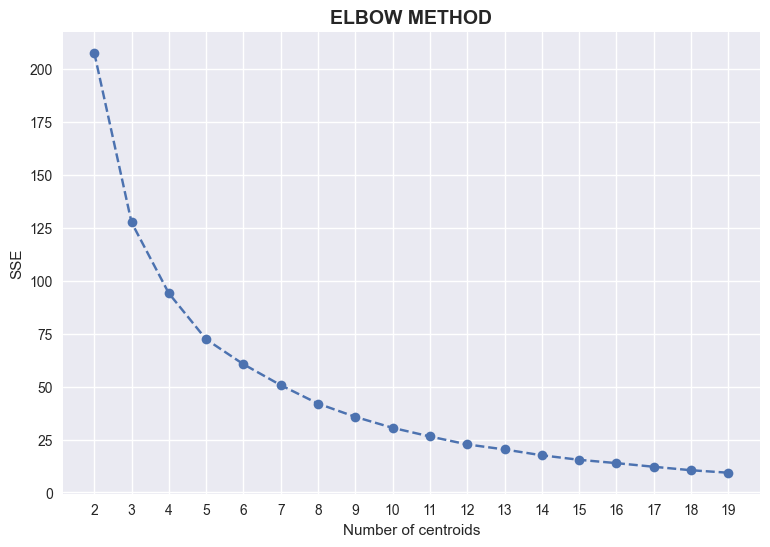

In [ ]:
plt.style.use('seaborn') # plot style
plt.figure(figsize=(9,6))
plt.plot(x, sse, marker='o', linestyle='--')
plt.title(f'ELBOW METHOD', fontdict={'weight': 'bold', 'size': 14})
plt.xlabel('Number of centroids')
plt.ylabel('SSE')
plt.xticks(x)
plt.show()

**Conclusiones**

Observando los gráficos, el silhouette averg y el elbow method concluimos que un k means con 4 clusters es el más adecuado

Inertia with 4 clusters:  93.8541    Silhouettte average for init=k-means++ with 4 clusters:  0.4437


Text(0.5, 1.0, 'nº of clusters = 4')

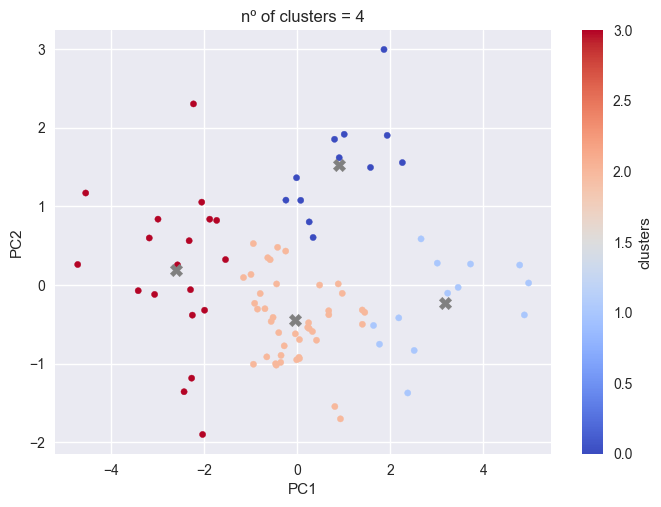

In [ ]:

kmean = KMeans(n_clusters=4, n_init=20, init='k-means++').fit(df_PCA.loc[:, ['PC1', 'PC2']]) # Apply the model   
sse = kmean.inertia_ # Calculate de sum of squared distance of each dataset point and its centroid
df_PCA[f'clusters'] = kmean.labels_
    
silhouette_avg = metrics.silhouette_score(df_PCA.loc[:, ['PC1', 'PC2']], kmean.labels_)
silhouette_samples = metrics.silhouette_samples(df_PCA.loc[:, ['PC1', 'PC2']], kmean.labels_)
df_PCA[f'silhouette'] = silhouette_samples
    
print(f'Inertia with 4 clusters: ', round(sse, 4), f'   Silhouettte average for init={init} with 4 clusters: ', round(silhouette_avg, 4))

ax = plt.gca()
df_PCA.plot.scatter(x='PC1', y='PC2', c='clusters', cmap='coolwarm', ax=ax)
    
centroids = kmean.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],  marker='X', c='grey', s=80)
plt.title(f'nº of clusters = 4')

#df_PCA

Observamos y estudiamos los distintos clusters

In [ ]:
print('Mean of variance of clusters: ', round(df_PCA.groupby('clusters').var().iloc[:,0:6].mean().mean(),4))

df_PCA.groupby('clusters').mean().iloc[:,0:6]

Mean of variance of clusters:  1.0967


,ML,LA,OR,BD,ST,PR
clusters,,,,,,
0,2.991667,4.529167,4.875000,5.091667,6.183333,6.491667
1,5.838462,6.980769,6.115385,6.373077,6.423077,6.969231
2,4.319048,5.320238,4.595238,4.730952,3.803571,3.586905
3,2.005263,3.771053,3.605263,2.942105,2.442105,1.652632


## Hierarchical Clustering

### Dendrograms for the different parameters

We create a function to plot the dendrograms

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


We plot the dendrograms with different parameters

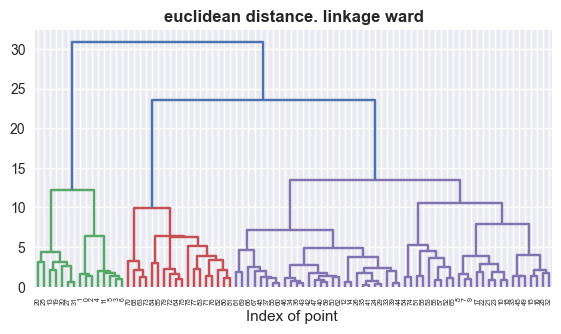

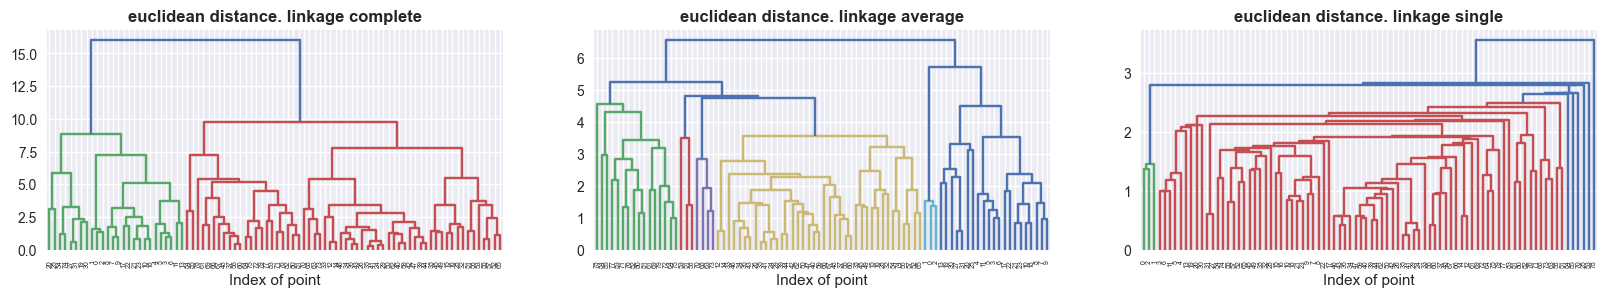

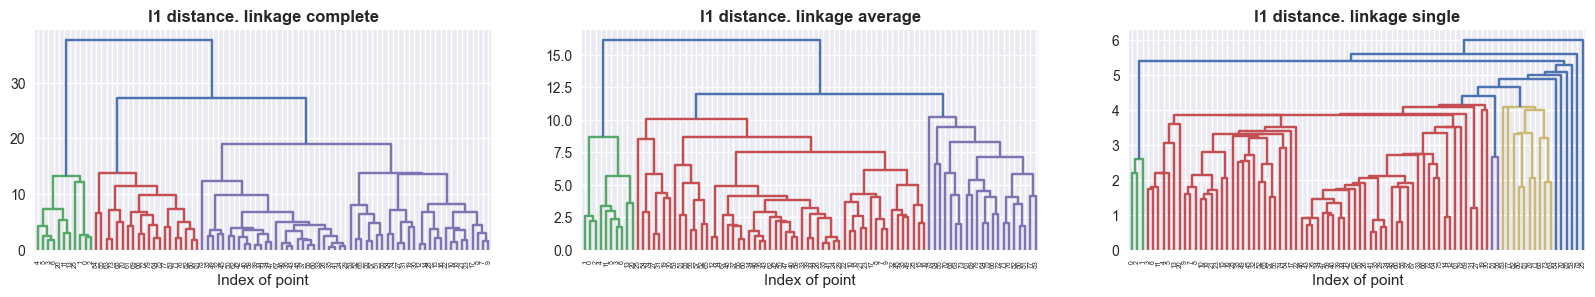

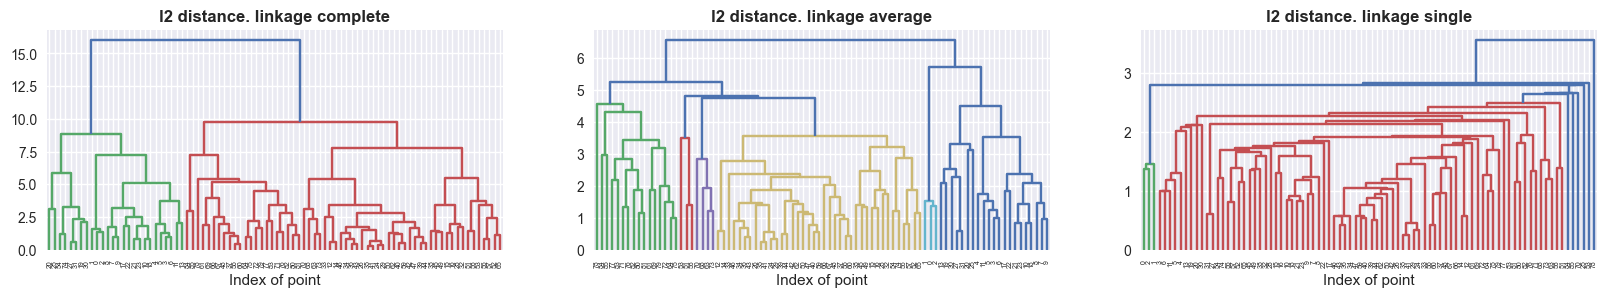

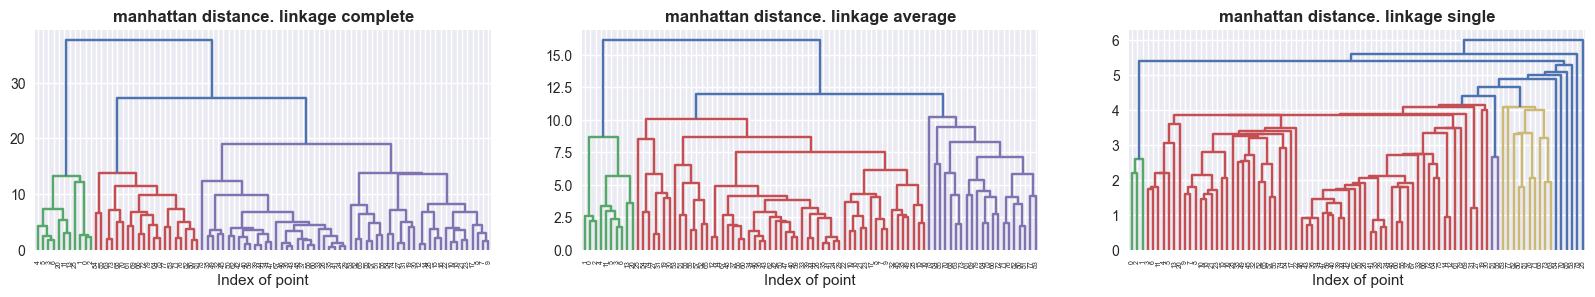

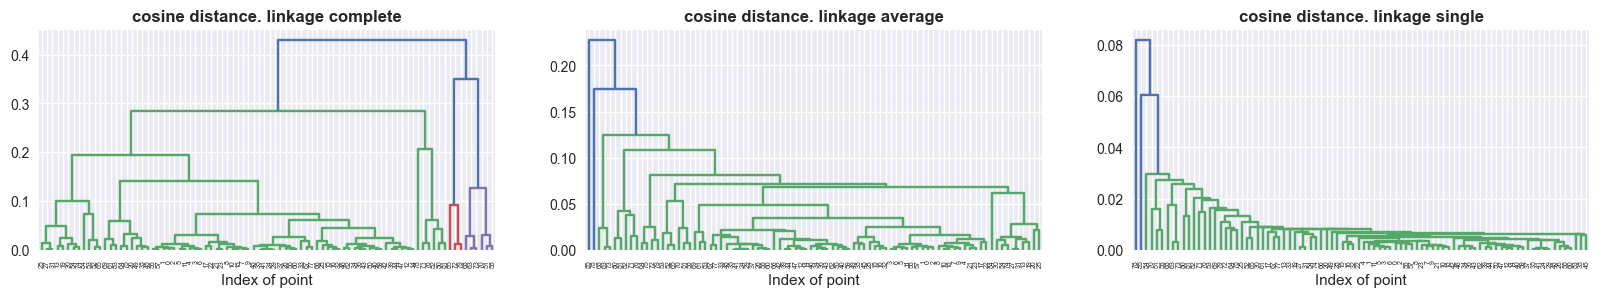

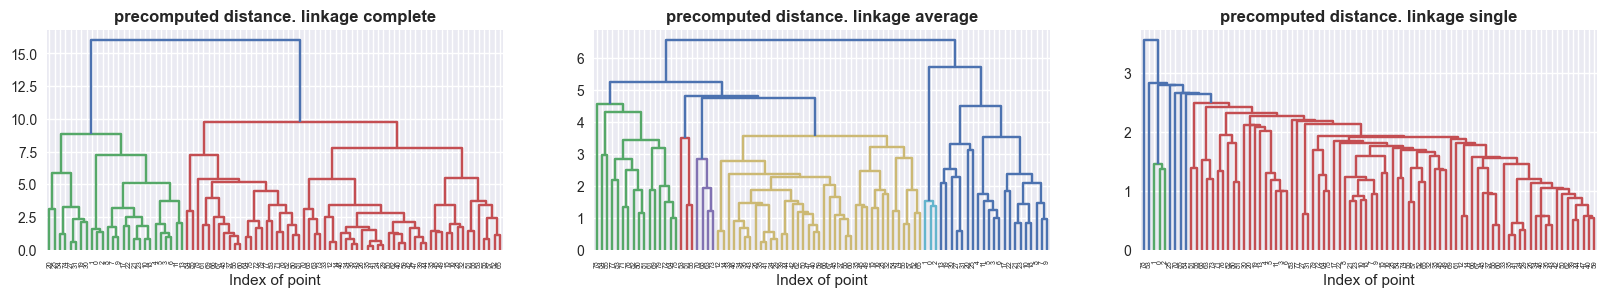

In [ ]:

# -------------We must plot the dendrogram with linkage=ward separately--------------------
plt.figure(figsize=(20/3,20/6))

single = AgglomerativeClustering(affinity="euclidean", distance_threshold=0, n_clusters=None, linkage="ward", compute_full_tree=True).fit(df.iloc[:,0:6])

# plot the all levels dendrogram
plot_dendrogram(single, truncate_mode="level", p=86)
plt.title(f"euclidean distance. linkage ward", fontdict={'weight': 'bold', 'size': 12})
plt.xlabel("Index of point ")
plt.show()

#----------------------------rest of dendrograms----------------------------
affinities = ["euclidean", "l1", "l2", "manhattan","cosine","precomputed"]
linkages = ["complete", "average", "single"]

i = 1 # for the subplots

for affinity in affinities:
    
    # if affinity is precomputed we have to fit the distance matrix
    if affinity == 'precomputed':
        dist_matrix = distance_matrix(df.iloc[:,0:6], df.iloc[:,0:6])
        plt.figure(figsize=(20,20))
        
        for linkage in linkages:
            plt.subplot(6,3,i)

            single = AgglomerativeClustering(affinity=affinity, distance_threshold=0, n_clusters=None, linkage=linkage, compute_full_tree=True).fit(dist_matrix)
            
            # plot the all levels dendrogram
            plot_dendrogram(single, truncate_mode="level", p=86)
            plt.title(f"{affinity} distance. linkage {linkage}", fontdict={'weight': 'bold', 'size': 12})
            plt.xlabel("Index of point")
            
            i+=1
            
        plt.show()
      
    else:
        plt.figure(figsize=(20,20))
        for linkage in linkages:

            plt.subplot(6,3,i)

            single = AgglomerativeClustering(affinity=affinity, distance_threshold=0, n_clusters=None, linkage=linkage, compute_full_tree=True).fit(df.iloc[:,0:6])
            
            # plot the all levels dendrogram
            plot_dendrogram(single, truncate_mode="level", p=86)
            plt.title(f"{affinity} distance. linkage {linkage}", fontdict={'weight': 'bold', 'size': 12})
            plt.xlabel("Index of point")
            
            i+=1

        plt.show()
        

**conclusion**


Los dendrogramas que mejor se ajustan a nuestros datos y que consideramos más lógicos según el `linkage` son los average linkage y el ward linkage, sin embargo, para los average linkage no está claro por donde cortar horizontalmente para crear los clusters, por eso decidimos quedarnos con ward linkage.

### Final execution and election of number of clusters

Nos hemos quedado con el dendrograma generado con linkage='ward' y distancia euclídea

#### Silhouette scores

Una de las métricas que vamos a usar para decidir por donde 'cortar' en el dendrograma son los silhouette scores. Es una métrica que nos indica como de 'bien' estan asociados los puntos a sus clusters. Un silhouette scores avg de 1 nos indica un clustering perfecto.

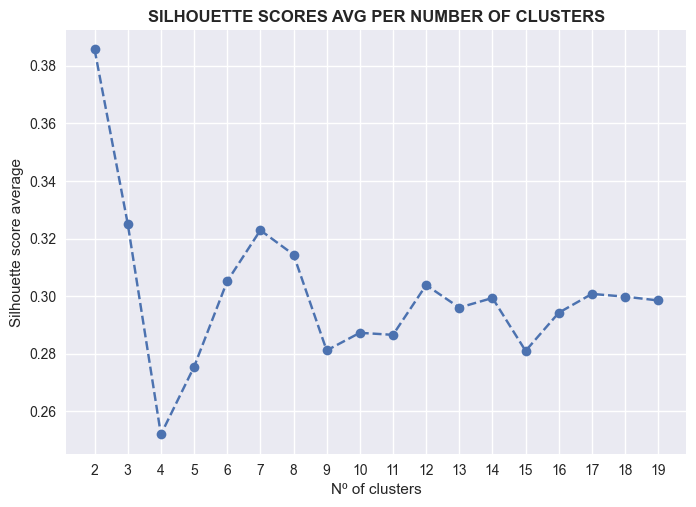

In [ ]:
sil = []
n_of_clusters = [i for i in range(2,20)]

for k in n_of_clusters:
    single = AgglomerativeClustering(compute_distances=True, n_clusters=k, affinity="euclidean", linkage="ward").fit(df.iloc[:,0:6])
    cluster_labels = single.labels_
    
    silhouette_avg = metrics.silhouette_score(df.iloc[:, 0:6], cluster_labels, metric='euclidean')
    sil += [silhouette_avg]

# ------------- plot of the silhouette scores avg for different number of clusters-------------
plt.plot(n_of_clusters, sil, marker='o', linestyle='--')

plt.xticks(n_of_clusters)
plt.title('SILHOUETTE SCORES AVG PER NUMBER OF CLUSTERS', fontdict={'weight': 'bold', 'size': 12})
plt.xlabel('Nº of clusters')
plt.ylabel('Silhouette score average')
plt.show()

#### Gap metric

La métrica que usaremos para hallar el número de clusters ideal es el **gap**, cuya finalidad es la de encontrar la mayor diferencia o distancia que hay entre los diferentes grupos de objetos que vamos formando para representarlos en un dendrograma. Para ello vamos cogiendo las distancias que hay de cada uno de los enlaces que forman el dendrograma y vemos cual es la mayor diferencia que hay entre cada uno de estos enlaces. 

In [ ]:
from scipy.cluster.hierarchy import linkage

def plot_gap(dataset):

    # Calculate distances between points or groups of points
    Z = linkage(dataset, metric='euclidean', method='ward')
    # Obtain the last 10 distances between points
    last = Z[-10:, 2]
    num_clustres = np.arange(1, len(last) + 1)

    # Calculate Gap
    gap = np.diff(last, n=2)  # second derivative
    plt.plot(num_clustres[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2, linestyle='--')

    plt.yticks([])
    plt.title('GAP METRIC', fontdict={'weight': 'bold', 'size': 12})
    plt.xlabel('Nº of clusters', fontdict={'weight': 'bold', 'size': 10})
    plt.ylabel('Distance', fontdict={'weight': 'bold', 'size': 10})

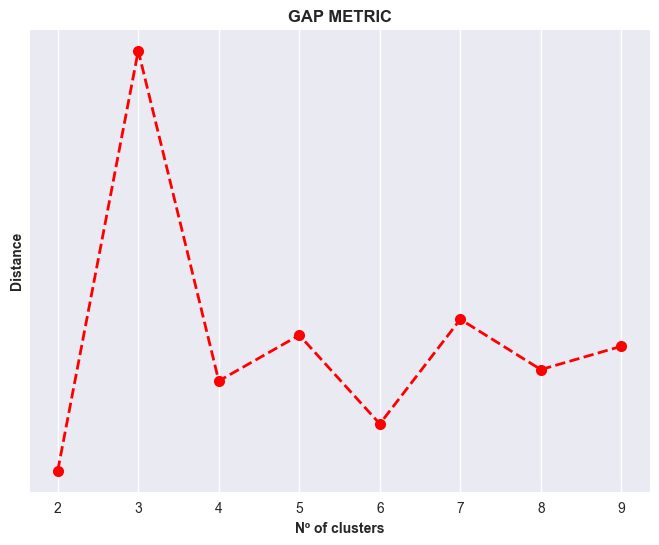

In [ ]:
plt.figure(figsize=(8, 6))
plot_gap(df.iloc[:, 0:6])
plt.show()

**OBSERVACIONES SOBRE EL SILHOUETTE COEFFICIENT**
- Observamos que el valor más alto se da para k=2 y luego le siguen 3 y 7. Aunque parezca mucha la diferencia entre dos y el resto, en realidad no lo es, pues todos los valores se mueven en el rango 0.2-0.4

**OBSERVACIONES SOBRE EL GAP METRIC**
- Es muy claro que el gap metric nos está indicando que el número ideal de clusters es 3.

**CONCLUSIÓN**: Teniendo en cuenta las dos métricas hemos llegado a la conclusión que el número óptimo de clusters para este agglomerative cluestering es 3.

#### Estudio del clustering (k=3, linkage=Ward, distance=euclidean)

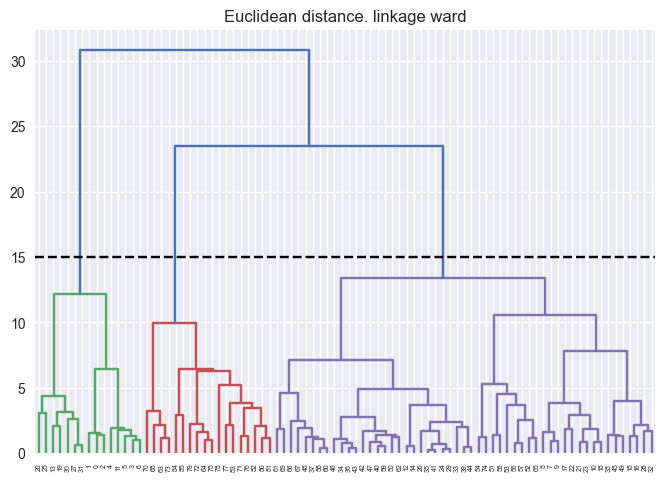

In [ ]:
altura_corte = 15
plot_dendrogram(single, color_threshold=altura_corte)
plt.title(f"Euclidean distance. linkage ward")
plt.axhline(y=altura_corte, c = 'black', linestyle='--')
plt.show()

In [ ]:
single = AgglomerativeClustering(compute_distances=True, n_clusters=3, affinity="euclidean", linkage="ward").fit(df.iloc[:,0:6])
df['agl clusters'] = single.labels_

**Análisis de los silhoeutte scores**

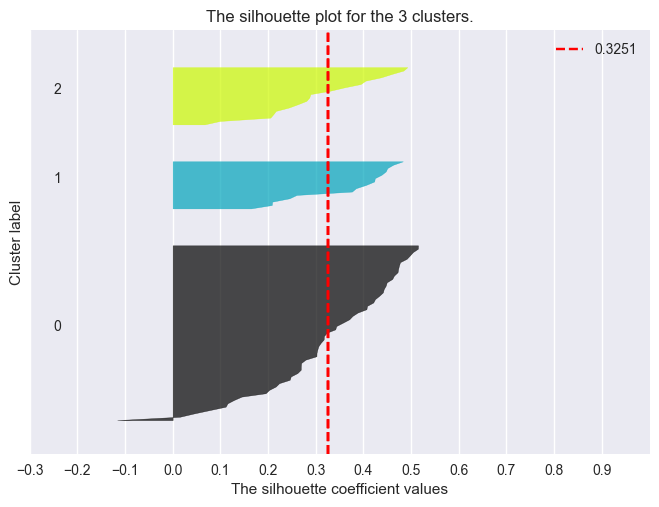

In [ ]:
cluster_labels = single.labels_

sample_silhouette_values = metrics.silhouette_samples(df.iloc[:, 0:6], cluster_labels, metric='euclidean')
silhouette_avg = metrics.silhouette_score(df.iloc[:, 0:6], cluster_labels, metric='euclidean') 

df['sil agl'] = sample_silhouette_values # Añadimos al df una columna con los silhouette para el aglomerative clustering definitivo

# --------------------pintamos el silhouette plot----------------------
y_lower = 10
    
for i in range(3):

    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.legend([round(silhouette_avg, 4)])
        
    color = cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    plt.text(-0.25, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

#plt configuration
plt.ylim([0, len(df.iloc[:, 0:6]) + (4) * 10])
plt.xlim([-0.3, 1])
plt.title(f"The silhouette plot for the {3} clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")
    
plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(-0.3, 1, 0.1))

plt.show()

Podemos ver que el cluster 0 es tiene bastantes más alumnos que los clusters 1 y 2, pero tienen silhouette scores, en general, más bajos.


**Número de instancias por cluster**

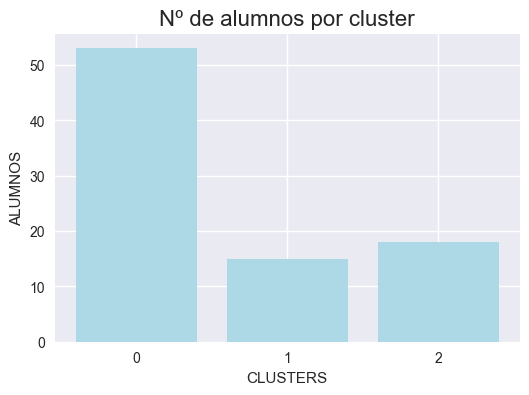

Nº de alumnos por cluster (cluster, nº): 
[(0, 53), (1, 15), (2, 18)]


In [ ]:
cl = sorted(list(df['agl clusters'].unique()))
num = list(df.groupby('agl clusters').count().iloc[:, 6])


plt.figure(figsize=(6, 4))
plt.bar(cl, num, color='lightblue')
plt.xlabel('CLUSTERS')
plt.ylabel('ALUMNOS')
plt.title('Nº de alumnos por cluster', fontsize=16)
plt.xticks([0, 1, 2])
plt.show()

print('Nº de alumnos por cluster (cluster, nº): ')
print(list(zip(cl, num)))

**Media de las asignaturas por cluster**

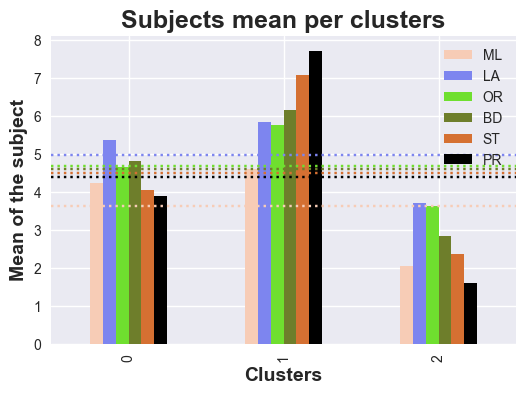

,ML,LA,OR,BD,ST,PR
agl clusters,,,,,,
0,4.245283,5.384906,4.669811,4.813208,4.056604,3.885849
1,4.613333,5.850000,5.766667,6.150000,7.090000,7.726667
2,2.061111,3.725000,3.638889,2.844444,2.361111,1.594444


In [ ]:
colors = ['#F7CCB6', '#7D85EF', '#6FDF2F', '#6E7E2B', '#D57032', 'black']

plt.figure(figsize=(6,4))
ax = plt.gca()

df.groupby('agl clusters').mean().iloc[:, 0:6].plot.bar(color = colors, ax=ax)

# DASHED LINES ARE THE TOTAL MEAN OF THE SUBJECTS
means = df.groupby('agl clusters').mean().iloc[:, 0:6].mean()
for m, c in zip(means, colors):
    ax.axhline(m, linestyle=':', c=c) 
    
plt.title('Subjects mean per clusters', fontdict={'weight': 'bold', 'size': 18})
plt.xlabel('Clusters', fontdict={'weight': 'bold', 'size': 14})
plt.ylabel('Mean of the subject', fontdict={'weight': 'bold', 'size': 14})
plt.show()

df.groupby('agl clusters').mean().iloc[:, 0:6]